# GWAS analysis for PD progression

Created 08/21/2018    
By Hirotaka Iwaki


### Predictors
1. Imputed variants with rsq > 0.8, maf > 0.05, and integer genotypes.
2. Variants in interest including 92 risk variants in the most recent meta-analysis, 
3. Genetic risk score composed of 92 risk variants. (Last)

### Outcomes

1. Binomial Outcomes:    
constipation(CONST), cognitive impairment (DEMENTIA), depressive mood (DEPR), dyskinesia (DYSKINESIAS), Hoehn Yahr Scale 3 or more (HY3), hyposmia (HYPOSMIA), insomnia (INS), motor fluctuations (MOTORFLUX), REM sleep behavior disorder (RBD), restless legs syndrome (RL), Modified Schwab and England Activities of Daily Living Scale 70 or less (SEADL70), daytime sleepiness (SLEEP)    


2. Contious Outcomes:    
Hoehn and Yahr scale (HY), MMSE, MoCA, SEADL, UPDRS_1/2/3/4/total    

### Analysis
For binomial outcomes;
1. **(lgsbl)** logistic regression analysis at baseline: logitsic regression
2. **(coxhm)** survival analysis for those who didn't have the symptom at the baseline: cox model with varying covariates.

For continous outcomes;
1. slope-analysis
    1. **(lnmxs)** Linear model with random intercept
    2. **(lncnx)** Conditional linear model orthogonal to time constant variable. 
2. intercept analysis
    1. **(lnmxi)** linear model with random intercept for repaeated obs.    
        (linear model for the cohort with single obs -> **lnsgl**)
    
### Covariates
1. Sex (FEMALE)
2. Years of Education (YEARSEDUC)
3. Family History (FAMILY_HISTORY)
4. Age at diagnosis (AAO)
5. Years from diagnosis at baseline for cox model (BLDfDIAG) / Years from diagnosis for glmm model (YEARfDIAG)
6. Treatment status (DOPA, AGNOIST)
7. Population structure (PC1-5)

### Meta-analysis
Fixed model

In [71]:
%%bash
# Predictors (Variants in interest)
cat predictor/_pos*.txt | LANG=C sort | uniq |sed '1 iPOS' > predictor/select.txt
awk -F' ' '/rs/{print $1,$2,$3}' predictor/_snp* | LANG=C sort | sed '1 iPOS ID NearGenpoe' |\
    sed 's/ /\t/g' | uniq -w 15 > predictor/snpInfo.txt
awk -F' ' '{print $1,toupper($4),$7}' predictor/Meta5.tab | sed 's/ /\t/g' | sed 's/chr//g' > predictor/grs.txt

In [103]:
%%bash
# create the data with individual (row) /snps (column) for selected SNPs in interst (R>0.8)
mkdir -p t
module load plink
for DATASET in $(ls ../dataset/);do
    plink --bfile /data/LNG/CORNELIS_TEMP/progression_GWAS/$DATASET/plink_files_hard/$DATASET.HARDCALLS \
        --extract predictor/select.txt --recodeA include-alt --out t/"$DATASET"_extract
    mkdir -p ../dataset/$DATASET/select_20Kcut
    N_COL=$(head -n1 t/"$DATASET"_extract.raw | sed 's/ /\n/g' | wc -l)
    N_SNP=$(expr $N_COL - 6) # first 6 columns (FID IID PAT MAT SEX PHENOTYPE)
    N_ITER=$(expr $(expr $N_SNP - 1) / 20000)  # number of iteration (couting up from 0)
    echo $DATASET N_COL_$N_COL N_SNP_$N_SNP N_ITER_$N_ITER
    for i in $(seq 0 $N_ITER);do
        echo $i
        START=$(expr 20000 \* $i + 7)
        if [ $i == $N_ITER ];then
            STOP=$N_COL
            cut -d" " -f2,"$START"-"$STOP" t/"$DATASET"_extract.raw | sed 's/ /\t/g' > ../dataset/$DATASET/select_20Kcut/cut"$i".txt
        else
            STOP=$(expr 20000 \* $(expr $i + 1) + 6)
            cut -d" " -f2,"$START"-"$STOP" t/"$DATASET"_extract.raw | sed 's/ /\t/g' > ../dataset/$DATASET/select_20Kcut/cut"$i".txt
        fi
    done
done

Process is terminated.


In [116]:
%%bash
# calculate scores.

## Rscript for score normalization for SCORE
echo '
args <- commandArgs(trailingOnly = TRUE)
INFILE = args[1]
df1 = read.csv(INFILE)
mean=mean(df1$SCORE)
sd=sd(df1$SCORE)
df1$SCORE=(df1$SCORE-mean)/sd
OUTFILE=paste("../dataset", substr(INFILE, 3,nchar(INFILE)-10), "score/M5grsZ.txt", sep="/")
write.table(df1, OUTFILE, row.names = F, quote = F, sep = "\t")
' > t/scoreNormalization.R

# Get grsZ 
module load plink
module load R
for DATASET in $(ls ../dataset/);do
    plink --bfile /data/LNG/CORNELIS_TEMP/progression_GWAS/$DATASET/plink_files_hard/$DATASET.HARDCALLS \
        --score predictor/grs.txt 1 2 3 header --out t/"$DATASET"_score
    awk 'BEGIN{OFS=","}{print $2,$6}' t/"$DATASET"_score.profile > t/"$DATASET"_score.txt
    mkdir -p ../dataset/$DATASET/score/
    Rscript --vanilla t/scoreNormalization.R t/"$DATASET"_score.txt
done >> /dev/null

# Get GBA score (0 for a mutation none carrier, 1 for otherwise)
echo '1:155205634 C 1
1:155206037 A 1
1:155206167 T 1' > predictor/gba.txt
module load plink
for DATASET in $(ls ../dataset/);do
    plink --bfile /data/LNG/CORNELIS_TEMP/progression_GWAS/$DATASET/plink_files_hard/$DATASET.HARDCALLS \
        --score predictor/gba.txt 1 2 3 sum --out t/"$DATASET"_score
    awk 'BEGIN{OFS="\t"}{t=($6>0);print $2,t}' t/"$DATASET"_score.profile |\
        sed '1 s/1/vGBA/' > ../dataset/$DATASET/score/gba.txt
done >> /dev/null

[+] Loading plink  1.9.0-beta4.4  on cn3274 
[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 
to allele code mismatch); see t/CORIELL_score.nopred for details.
to allele code mismatch); see t/DATATOP_score.nopred for details.
to allele code mismatch); see t/DIGPD_chip_score.nopred for details.
to allele code mismatch); see t/DIGPD_neuroX_score.nopred for details.
to allele code mismatch); see t/HBS_score.nopred for details.
to allele code mismatch); see t/OSLO_score.nopred for details.
to allele code mismatch); see t/PARKFIT_score.nopred for details.
to allele code mismatch); see t/PARKWEST_score.nopred for details.
to allele code mismatch); see t/PDBP_score.nopred for details.
to allele code mismatch); see t/PICNICS_score.nopred for details.
to allele code mismatch); see t/PPMI_score.nopred for details.
to allele code mismatch); see t/PRECEPT_score.nopred for details.
to allele code mismatch); see

In [36]:
%%bash
# Create Phenotype files

FOLDER=pheno
mkdir -p $FOLDER
cd $FOLDER
for DATASET in $(ls ../../dataset/);do
#     mkdir -p $DATASET
#     cd $DATASET
    mkdir -p lgsbl
    mkdir -p coxhm
    mkdir -p lnmxs
    mkdir -p lncns
    mkdir -p lnmxi
    mkdir -p lnsgl
done


# 1    Need to match phenotype ID and IID.
# 1.1    Extract IID from imputed file
rm t/_IDlist_imputed.txt
for DATASET in $(ls ../dataset);do
  cat /data/LNG/CORNELIS_TEMP/progression_GWAS/$DATASET/plink_files_hard/*.fam | sed "s/^/$DATASET:/g" | cut -f1 | cut -d " " -f1 | sed 's/:/'$'\t/g' >> t/_IDlist_imputed.txt
done
# 1.2    Creating HBS ID matching file. (No formal table so compare genotyping file)
module load plink
GNTYP_IN=/data/LNG/CORNELIS_TEMP/progression_GWAS/
plink --bfile data/HBS_original/pruned --bmerge $GNTYP_IN/pre_impute_data/HBS --make-bed --out t/V1
plink --bfile data/HBS_original/pruned --exclude t/V1-merge.missnp --make-bed --out t/V2
plink --bfile t/V2 --bmerge $GNTYP_IN/pre_impute_data/HBS --make-bed --out t/V3
plink --bfile t/V3 --genome --min 0.7 --out t/V4
mv t/V4.genome data/HBSIDmatch.txt
# 1.3    
module load R
Rscript --vanilla CreatePhenoFile.R

In [4]:
%%bash
# Create output folders
for FOLDER in output outGWAS outGRS;do
    mkdir -p $FOLDER
    cd $FOLDER
    for DATASET in $(ls ../../dataset/);do
        mkdir -p $DATASET
        cd $DATASET
        mkdir -p lgsbl
        mkdir -p coxhm
        mkdir -p lnmxs
        mkdir -p lncns
        mkdir -p lnmxi
        mkdir -p lnsgl
        cd ..
    done
    cd ..
done

In [1]:
%%bash
# Cohort level analysis with plink (lgsbl and lnsgl)

## GENOTYPE folder
GNTYP=/data/LNG/CORNELIS_TEMP/progression_GWAS


### Create Swarm file for plink regression analysis. 
mkdir -p swarm
rm -f swarm/plinkreg_all.txt
for DATASET in $(ls ../dataset/);do
    FILE=$GNTYP/$DATASET/plink_files_hard/$DATASET.HARDCALLS # plink bfile location
    for EXTRACT in "predictor/select.txt" "../dataset/$DATASET/maf05rsq8.info";do # plink extract
        if [ $EXTRACT == "predictor/select.txt" ];then
            OUTPUT=output # for plink output address
        else
            OUTPUT=outGWAS
        fi
        for MODEL in lgsbl lnsgl;do
            PHENOFILE=pheno/$MODEL/"$DATASET".txt # plink pheno file
            COVFILE=pheno/$MODEL/"$DATASET"_cov.txt # plink covfile
            if [ $MODEL == lgsbl ];then
                ANALYSIS=logistic # plink analysis model
            else
                ANALYSIS=linear
            fi
            for i in $(grep $MODEL";"$DATASET 'models.txt');do
                OUTCOME=$(echo $i | cut -d";" -f3) # plink pheno-name
                COVNAME=$(echo $i | cut -d";" -f4) # plink cov-name
                OUT=$OUTPUT/$DATASET/$MODEL/$OUTCOME # plink output address
                mkdir -p $OUT
                echo "
plink --bfile $FILE --extract $EXTRACT --$ANALYSIS beta \
--pheno $PHENOFILE --pheno-name $OUTCOME \
--covar $COVFILE --covar-name $COVNAME,PC1,PC2,PC3,PC4,PC5 \
--allow-no-sex --hide-covar --ci 0.95 --out $OUT ;\
awk '" 'BEGIN{OFS="\t"}{print $2,$4,$7,$8,$12}' "' $OUT.assoc.$ANALYSIS |\
awk 'NR==1{print;next}{print|\"LANG=C sort\"}' |\
LANG=C join -t$'\t' --header $FILE.A2 - |\
LANG=C join --header -t$'\t' - ../dataset/$DATASET/maf001rsq3.info |\
cut -f-7 | awk 'BEGIN{OFS=\"\\t\"}{t=\$2;\$2=\$3;\$3=t;print \$0}'> $OUT/all.tab" >> swarm/plinkreg_all.txt
            done
        done
    done
done

grep 'select.txt' swarm/plinkreg_all.txt > swarm/plinkreg_output.txt
grep 'maf05rsq8.info' swarm/plinkreg_all.txt > swarm/plinkreg_outGWAS.txt
swarm -f swarm/plinkreg_output.txt --time=0:03:00 -g 2 -p 2 -b 32 --logdir swarm/plinkreg --module plink --devel
swarm -f swarm/plinkreg_outGWAS.txt --time=0:10:00 -g 2 -p 2 -b 10 --logdir swarm/plinkreg --module plink --devel

Loading modules plink
64 commands run in 2 subjobs, each command requiring 2 gb and 1 thread, packing 2 processes per subjob, running 25 processes serially per subjob
sbatch --array=0-1 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=4096 --partition=norm --time=01:15:00 /spin1/swarm/iwakih2/4kLe8_bT31/swarm.batch
Loading modules plink
64 commands run in 4 subjobs, each command requiring 2 gb and 1 thread, packing 2 processes per subjob, running 10 processes serially per subjob
sbatch --array=0-3 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=4096 --partition=norm --time=01:40:00 /spin1/swarm/iwakih2/42EvLpkTfE/swarm.batch


In [ ]:
%%bash
# For genetic risk score, use R for the analysis. 
echo '
library(dplyr);library(data.table)
DATASETs=list.files("../dataset/")
DATASET=DATASETs[1]
SCOREs=list.files(paste("../dataset", DATASET, "grs", sep="/"),)
'

In [2]:
%%bash 
# Cohort level analysis with R (coxhm lncns, lnmxs and lnmxi)

## coxhm 
# e.g. Rscript --vanilla _surv.R DIGPD_chip CONST  ../dataset/CORIELL/maf05rsq8_20Kcut/cut264.txt outGWAS
echo '
args <- commandArgs(trailingOnly = TRUE)
# set variables
DATASET = args[1]
OUTCOME = args[2]
INFILE  = args[3]
OUT     = args[4]
library(data.table);library(dplyr);library(survival)
# Read data
cohort=fread(paste("pheno/coxhm/", OUTCOME, "_", DATASET, ".txt", sep = "")) %>% arrange(IID, TSTART)
COVs = paste(names(cohort)[-c(1:3,ncol(cohort)-5:7)], collapse=" + ") # dropb c(ID, TSTART, OUTCOME, BEGIN, END, TSTOP)
## Imputed data
SNPset = fread(INFILE)
SNPs = names(SNPset)[-1] # 1 IID, SNP name starts from col2
## Merge
cohort_snp = left_join(cohort, SNPset, by = "IID")
cohort_snp$SurvObj1 = with(cohort_snp, Surv(TSTART, TSTOP, OUTCOME == 1))
surv.listfunc = function(x){
  # Models
  MODEL = paste("SurvObj1 ~", "`", SNPs[x], "`+", COVs, sep = "")
  testCox = try(coxph(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testCox)[1]=="try-error"){
    sumstat=c(SNPs[x], "NoConverge", rep(NA,4))
  }else{
    temp= summary(testCox)$coefficients
    if(grep(substr(SNPs[x],1,7), rownames(temp)) %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=c(SNPs[x], "NoVforSNP", rep(NA, 4))
    }else{
      RES = temp[1,]
      EVENT_OBS = paste(testCox$nevent, testCox$n, sep="_")
      sumstat <- c(SNPs[x], EVENT_OBS, as.numeric(RES[4]), RES[1], RES[3], RES[5])
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), surv.listfunc)
temp2 = do.call(rbind, temp)
attributes(temp2)$dimnames[[2]]=c("POS_A1(/A2)", "OBS_N", "Tvalue", "BETA", "SE", "P")
NEWDIR = paste(OUT, DATASET, "coxhm", OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
write.table(temp2, paste(NEWDIR, strsplit(INFILE, "/")[[1]][5], sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/coxhm.R", DATASET, OUTCOME, INFILE, OUT, sep=" ")
write(line,file=paste("finish_", strsplit(INFILE, "/")[[1]][4], ".txt", sep=""),append=TRUE)
' > t/coxhm.R

# Conditional linear regression model
echo '
args <- commandArgs(trailingOnly = TRUE)
# set variables
DATASET = args[1]
OUTCOME = args[2]
INFILE  = args[3]
OUT     = args[4]
library(data.table);library(dplyr)
# Read phenotype data
cohort=fread(paste("pheno/lncns/", OUTCOME, "_", DATASET, ".txt", sep = "")) %>%
  filter(complete.cases(.)) %>% arrange(IID, YEARfDIAG)
OBS_N=paste(nrow(cohort), length(unique(cohort$IID)), sep="_")

## Read Imputed data
SNPset = fread(INFILE)
SNPnames = names(SNPset)[-1] # -ID

# Replace average value for missing SNPs
S = SNPset[,-1] %>% as.matrix
W = !is.na(S) # missing indicator matrix
NMISS = sum(W==FALSE)
if(NMISS>0){MISS=paste(NMISS, "MISS CELLs")}else{MISS=""}
Imp=colSums(W*S)/colSums(W)
S = W * S + (1-W) * Imp
SNPset=data.frame(SNPset[,1], S) # good SNPset

## Merge with longitudinal data
cohort_snp = left_join(cohort, SNPset, by = "IID")
# Create SNPs slope effect matrix
S=cohort_snp[, (ncol(cohort)+1):ncol(cohort_snp)] %>% as.matrix
S= S * cohort$YEARfDIAG
# data transpose to N(Xt) space
X = cohort[,-c(1, ncol(cohort))] %>% as.matrix # -ID, -OUTCOME
y = cohort[,ncol(cohort)] %>% as.vector
U1 = crossprod(X, y)
U2 = solve(crossprod(X), U1)
ytr = y - X %*% U2
U3 = crossprod(X, S)
U4 = solve(crossprod(X), U3)
Str = S - X %*% U4
Str2 = colSums(Str^2)
b = as.vector(crossprod(ytr, Str)/Str2)
sigma = (sum(ytr^2) - b^2 * Str2) / (nrow(cohort) - ncol(X) - 2)
err = sqrt(sigma * (1/Str2))
p = 2 * pnorm(-abs(b/err))
df = data.frame(V1=SNPnames, V2=OBS_N, V3=-9, V4=b, V5=err, V6=p)
names(df)=c("POS_A1(/A2)", "OBS_N", "Tvalue", "BETA", "SE", "P")

# OUT
NEWDIR = paste(OUT, DATASET, "lncns", OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
write.table(df, paste(NEWDIR, strsplit(INFILE, "/")[[1]][5], sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/lncns.R", DATASET, OUTCOME, INFILE, OUT, MISS, sep=" ")
write(line,file=paste("finish_", "lncns", strsplit(INFILE, "/")[[1]][4], ".txt", sep=""),append=TRUE)
' > t/lncns.R

## lnmxi
echo '
args <- commandArgs(trailingOnly = TRUE)
# set variables
DATASET = args[1]
OUTCOME = args[2]
INFILE  = args[3]
OUT     = args[4]
library(data.table);library(dplyr);library(lme4)
# Read data
cohort=fread(paste("pheno/lnmxi/", DATASET, ".txt", sep = "")) %>% arrange(IID, YEARfDIAG)
COVs = names(cohort)[grep("^FEMALE|^YEARSEDUC|^FAMILY_HISTORY|^AAO|^YEARfDIAG|^DOPA|^AGNOIST|^PC", names(cohort))]
cohort = cohort %>% select(IID, OUTCOME, COVs) %>% filter(complete.cases(.))
## Imputed data
SNPset = fread(INFILE)
SNPs = names(SNPset)[-1] # 1 IID, SNP name starts from col2
## Merge
cohort_snp = left_join(cohort, SNPset, by = "IID")
glmm.listfunc = function(x){
  # Models
  MODEL = paste(OUTCOME, "~", "`", SNPs[x], "`+", paste(COVs, collapse="+"), "+(1|IID)", sep = "")
  testLmer = try(lmer(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testLmer)[1]=="try-error"){
    sumstat=rep("DROP",6)
  }else{
    temp = summary(testLmer)
    temp1 = temp$coefficients
    if(grep(substr(SNPs[x],1,7), rownames(temp1)) %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=rep(NA,6)
    }else{
      RES = temp1[2,] # The first row is intercept
      PV_APPROX = 2 * pnorm(-abs(RES[3])) # df is enough large for approximation
      OBS_N = paste(length(temp$residuals), "_", temp$ngrps, sep="")
      sumstat <- c(SNPs[x], OBS_N, RES[3], RES[1], RES[2], PV_APPROX)
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), glmm.listfunc)
temp2 = do.call(rbind, temp)
attributes(temp2)$dimnames[[2]]=c("POS_A1(/A2)", "OBS_N", "Tvalue", "BETA", "SE", "P")
NEWDIR = paste(OUT, DATASET, "lnmxi", OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
write.table(temp2, paste(NEWDIR, strsplit(INFILE, "/")[[1]][5], sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/lnmxi.R", DATASET, OUTCOME, INFILE, OUT, sep=" ")
write(line,file=paste("finish_", strsplit(INFILE, "/")[[1]][4], ".txt", sep=""),append=TRUE)
' > t/lnmxi.R



## lnmxs
echo '
args <- commandArgs(trailingOnly = TRUE)
# set variables
DATASET = args[1]
OUTCOME = args[2]
INFILE  = args[3]
OUT     = args[4]
library(data.table);library(dplyr);library(lme4)
# Read data
cohort=fread(paste("pheno/lnmxs/", DATASET, ".txt", sep = "")) %>% arrange(IID, YEARfDIAG)
COVs = names(cohort)[grep("^FEMALE|^YEARSEDUC|^FAMILY_HISTORY|^AAO|^YEARfDIAG|^DOPA|^AGNOIST|^PC", names(cohort))]
cohort = cohort %>% select(IID, OUTCOME, COVs) %>% filter(complete.cases(.))
## Imputed data
SNPset = fread(INFILE)
SNPs = names(SNPset)[-1] # 1 IID, SNP name starts from col2
## Merge
cohort_snp = left_join(cohort, SNPset, by = "IID")
glmm.listfunc = function(x){
  # Models
  MODEL = paste(OUTCOME, "~", "`", SNPs[x], "`+ `", SNPs[x], "`*YEARfDIAG + ", paste(COVs, collapse="+"), "+(1 + YEARfDIAG |IID)", sep = "")
  testLmer = try(lmer(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testLmer)[1]=="try-error"){
    sumstat=rep("DROP",6)
  }else{
    temp = summary(testLmer)
    temp1 = temp$coefficients
    if(grep(substr(SNPs[x],1,7), rownames(temp1)) %>% length < 2){ # In this case, SNP_slope is dropeed from the model
      sumstat=rep(NA,6)
    }else{
      RES = temp1[nrow(temp1),] # The last row is intercept
      PV_APPROX = 2 * pnorm(-abs(RES[3])) # df is enough large for approximation
      OBS_N = paste(length(temp$residuals), "_", temp$ngrps, sep="")
      sumstat <- c(SNPs[x], OBS_N, RES[3], RES[1], RES[2], PV_APPROX)
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), glmm.listfunc)
temp2 = do.call(rbind, temp)
attributes(temp2)$dimnames[[2]]=c("POS_A1(/A2)", "OBS_N", "Tvalue", "BETA", "SE", "P")
NEWDIR = paste(OUT, DATASET, "lnmxs", OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
write.table(temp2, paste(NEWDIR, strsplit(INFILE, "/")[[1]][5], sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/lnmxs.R", DATASET, OUTCOME, INFILE, OUT, sep=" ")
write(line,file=paste("finish_", strsplit(INFILE, "/")[[1]][4], ".txt", sep=""),append=TRUE)
' > t/lnmxs.R

In [3]:
%%bash
# Create swarm for R analyses
rm -f swarm/ln*.txt swarm/coxhm*.txt swarm/ln*/* swarm/coxhm*/*
for FOLDER in "maf05rsq8_20Kcut" "select_20Kcut" "score";do
    if [ $FOLDER == maf05rsq8_20Kcut ];then
        OUTPUT=outGWAS
    elif [ $FOLDER == select_20Kcut ];then
        OUTPUT=output
    else
        OUTPUT=outGRS
    fi
    for i in $(tail -n +2 models.txt);do
        MODEL=$(echo $i | cut -d";" -f1)
        DATASET=$(echo $i | cut -d";" -f2)
        OUTCOME=$(echo $i | cut -d";" -f3) # plink pheno-name
        for INFILE in $(ls ../dataset/$DATASET/$FOLDER/*);do
        echo "Rscript --vanilla t/$MODEL.R $DATASET $OUTCOME $INFILE $OUTPUT" >> swarm/"$MODEL"_"$OUTPUT".txt 
        done
    done
done

MODEL=coxhm
echo "
swarm -f swarm/"$MODEL"_outGWAS.txt --time=0:30:00 -g 2 -p 2 -b 36 --logdir swarm/"$MODEL"_outGWAS --module R --devel
swarm -f swarm/"$MODEL"_output.txt --time=0:03:00 -g 2 -p2 -b 38 --logdir swarm/"$MODEL"_output --module R --devel
swarm -f swarm/"$MODEL"_outGRS.txt --time=0:01:00 -g 2 -b 52 --logdir swarm/"$MODEL"_outGRS --module R --devel"

MODEL=lncns
echo "
swarm -f swarm/"$MODEL"_outGWAS.txt --time=0:03:00 -g 2 -p 2 -b 100 --logdir swarm/"$MODEL"_outGWAS --module R --devel
swarm -f swarm/"$MODEL"_output.txt --time=0:01:00 -g 2 -b 74 --logdir swarm/"$MODEL"_output --module R --devel
swarm -f swarm/"$MODEL"_outGRS.txt --time=0:01:00 -g 2 -b 74 --logdir swarm/"$MODEL"_outGRS --module R --devel"

for MODEL in lnmxs lnmxi;do
echo "
swarm -f swarm/"$MODEL"_outGWAS.txt --time=2:00:00 -g 2 -p 2 -b 12 --logdir swarm/"$MODEL"_outGWAS --module R --devel
swarm -f swarm/"$MODEL"_output.txt --time=0:10:00 -g 2 -b 74 --logdir swarm/"$MODEL"_output --module R --devel
swarm -f swarm/"$MODEL"_outGRS.txt --time=0:03:00 -g 2 -b 74 --logdir swarm/"$MODEL"_outGRS --module R --devel"
done



swarm -f swarm/coxhm_outGWAS.txt --time=0:30:00 -g 2 -p 2 -b 36 --logdir swarm/coxhm_outGWAS --module R --devel
swarm -f swarm/coxhm_output.txt --time=0:03:00 -g 2 -b 52 --logdir swarm/coxhm_output --module R --devel
swarm -f swarm/coxhm_outGRS.txt --time=0:01:00 -g 2 -b 52 --logdir swarm/coxhm_outGRS --module R --devel

swarm -f swarm/lncns_outGWAS.txt --time=0:03:00 -g 2 -p 2 -b 100 --logdir swarm/lncns_outGWAS --module R --devel
swarm -f swarm/lncns_output.txt --time=0:01:00 -g 2 -b 74 --logdir swarm/lncns_output --module R --devel
swarm -f swarm/lncns_outGRS.txt --time=0:01:00 -g 2 -b 74 --logdir swarm/lncns_outGRS --module R --devel

swarm -f swarm/lnmxs_outGWAS.txt --time=2:00:00 -g 2 -p 2 -b 12 --logdir swarm/lnmxs_outGWAS --module R --devel
swarm -f swarm/lnmxs_output.txt --time=0:10:00 -g 2 -b 74 --logdir swarm/lnmxs_output --module R --devel
swarm -f swarm/lnmxs_outGRS.txt --time=0:03:00 -g 2 -b 74 --logdir swarm/lnmxs_outGRS --module R --devel

swarm -f swarm/lnmxi_outGWAS.

ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ../dataset/CORIELL/grs/*: No such file or directory
ls: cannot access ..

In [95]:
%%bash
## lnsgl -> lnmxi (only 1 model == lnsgl;PARKFIT;MMSE;FEMALE,AAO,YEARfDIAG)
for i in $(ls */*/lnsgl/*/all.tab);do
    NEWDIR=$(echo $i | sed 's/lnsgl/lnmxi/' | sed 's/\/all.tab//')
    mkdir -p $NEWDIR
    cp $i $NEWDIR
done

In [100]:
%%bash
# populate all the R results into one file (all.tab) Time consuming process.
rm -f swarm/populate*.txt
for RESULT in "output" "outGWAS" "outGRS";do  
    for MODEL in coxhm lncns lnmxi lnmxs;do
        for i in $(grep ^"$MODEL" models.txt);do
            DATASET=$(echo $i | cut -d";" -f2)
            OUTCOME=$(echo $i | cut -d";" -f3)
            echo "
cat $RESULT/$DATASET/$MODEL/$OUTCOME/*.txt | sed 's/_/\t/g' | sed 's/(\//\t/g' | sed 's/)//g' |\
 cut -f 1-3,7-9 | awk 'NR==1{print;next}{print|\"LANG=C sort\"}' |\
 LANG=C join -t$'\t' --header - ../dataset/$DATASET/maf001rsq3.info | cut -f-7 > $RESULT/$DATASET/$MODEL/$OUTCOME/all.tab" \
 >> swarm/populate_"$RESULT".txt
            done
    done
done

swarm -f swarm/populate_outGWAS.txt --time=0:04:00 -g 2 -p 2 -b 82 --logdir swarm/populate --devel
swarm -f swarm/populate_output.txt --time=0:02:00 -g 2 -p 2 -b 82 --logdir swarm/populate --devel
swarm -f swarm/populate_outGRS.txt --time=0:02:00 -g 2 -p 2 -b 82 --logdir swarm/populate --devel

In [117]:
%%bash
# populate all the R results into one file (all.tab) Time consuming process.
rm swarm/populate_output.txt
for RESULT in "output";do  
    for MODEL in lnmxs;do
        for i in $(grep ^"$MODEL" models.txt);do
            DATASET=$(echo $i | cut -d";" -f2)
            OUTCOME=$(echo $i | cut -d";" -f3)
            echo "
cat $RESULT/$DATASET/$MODEL/$OUTCOME/*.txt | sed 's/_/\t/g' | sed 's/(\//\t/g' | sed 's/)//g' |\
 cut -f 1-3,7-9 | awk 'NR==1{print;next}{print|\"LANG=C sort\"}' |\
 LANG=C join -t$'\t' --header - ../dataset/$DATASET/maf001rsq3.info | cut -f-7 > $RESULT/$DATASET/$MODEL/$OUTCOME/all.tab" \
 >> swarm/populate_"$RESULT".txt
            done
    done
done

swarm -f swarm/populate_outGWAS.txt --time=0:04:00 -g 2 -p 2 -b 82 --logdir swarm/populate --devel
swarm -f swarm/populate_output.txt --time=0:02:00 -g 2 -p 2 -b 82 --logdir swarm/populate --devel
swarm -f swarm/populate_outGRS.txt --time=0:02:00 -g 2 -p 2 -b 82 --logdir swarm/populate --devel

325 commands run in 2 subjobs, each command requiring 2 gb and 1 thread, packing 2 processes per subjob, running 82 processes serially per subjob
sbatch --array=0-1 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=4096 --partition=norm --time=05:28:00 /spin1/swarm/iwakih2/TqQiZpR6aA/swarm.batch
74 commands run in 1 subjob, each command requiring 2 gb and 1 thread, packing 74 processes per subjob, running 74 processes serially per subjob
sbatch --array=0-0 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=74 --mem=151552 --partition=norm --time=01:14:00 /spin1/swarm/iwakih2/YXRB8ogfMI/swarm.batch
325 commands run in 2 subjobs, each command requiring 2 gb and 1 thread, packing 2 processes per subjob, running 82 processes serially per subjob
sbatch --array=0-1 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=4096 --partition=norm --time=02:44:00 /spin1/swarm/iwakih2/iwwS7S03cE/swarm.batch


In [4]:
%%bash
# MetaAnalysis by METAL. But R will be used for GRS meta-analysis. 

## First create files ready for meta analysis
# Logistic regression at baseline

for RESULT in "output" "outGWAS";do
    rm -f meta/$RESULT/*/*.metal
    for i in $(tail -n +2 models.txt);do
        MODEL=$(echo $i | cut -d";" -f1)
        DATASET=$(echo $i | cut -d";" -f2)
        OUTCOME=$(echo $i | cut -d";" -f3)
        if [ $MODEL == "lnsgl" ];then # lnsgl will be combined with lnmxi
            MODEL=lnmxi
        fi
        mkdir -p meta/$RESULT/$MODEL
        echo "
MARKER POS
ALLELE A1 A2
FREQ   ALT_Frq
EFFECT BETA
PVALUE P
STDERR SE
PROCESS $RESULT/$DATASET/$MODEL/$OUTCOME/all.tab" >> meta/$RESULT/$MODEL/$OUTCOME.metal
    done
done
for i in $(ls meta/*/*/*.metal);do
    sed -i -e '1 iSCHEME STDERR\nAVERAGEFREQ ON\nMINMAXFREQ ON' \
    -e "\$aOUTFILE $(echo $i | cut -d"." -f1) .tbl\nANALYZE HETEROGENEITY\nQUIT" $i
done

In [5]:
%%bash
rm -f swarm/metal.txt
for i in $(ls meta/*/*/*.metal);do
    echo "metal $i" >> swarm/metal.txt
done
rm -rf swarm/metal
grep 'outGWAS' swarm/metal.txt > swarm/metal_outGWAS.txt
swarm -f swarm/metal_outGWAS.txt -g 6 -p 2 -b 6 --time=1:00:00 --module metal --logdir swarm/metal --devel
grep 'output' swarm/metal.txt > swarm/metal_output.txt
swarm -f swarm/metal_output.txt -g 6 -p 2 -b 13 --time=0:10:00 --module metal --logdir swarm/metal --devel

Loading modules metal
51 commands run in 5 subjobs, each command requiring 6 gb and 1 thread, packing 2 processes per subjob, running 6 processes serially per subjob
sbatch --array=0-4 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=12288 --partition=norm --time=06:00:00 /spin1/swarm/iwakih2/m3hlAgnaRW/swarm.batch
Loading modules metal
51 commands run in 2 subjobs, each command requiring 6 gb and 1 thread, packing 2 processes per subjob, running 17 processes serially per subjob
sbatch --array=0-1 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=12288 --partition=norm --time=02:50:00 /spin1/swarm/iwakih2/x5Qm73pq3O/swarm.batch


In [19]:
%%bash
module load metal
metal meta/outGWAS/lncns/HY.metal

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                     (default = 'PVALUE')
#   DEFAUL

[+] Loading metal  2017-12-21 


In [7]:
%%bash
echo '
args <- commandArgs(trailingOnly = TRUE)
# set variables
INFILE  = args[1]
OUT = gsub("/", "_", substr(INFILE,6,nchar(INFILE)-5)) # outGWAS-lncns-HY
library(data.table)
data =  fread(paste("cut -f 10", INFILE))
data$P = as.numeric(data$`P-value`)
observed <- sort(data$P)
lobs <- -(log10(observed))
expected <- c(1:length(observed)) 
lexp <- -(log10(expected / (length(expected)+1)))
Mchisq <- qchisq(median(data$P),1,lower.tail=F)
lambda = Mchisq/qchisq(0.5,1)
# alternative can also do pdf("")
png(paste("fig/", OUT, ".png", sep=""))
# optional can change the dimensions of the plot by editing the (0,17) to smaller or bigger numbers
plot(c(0,17), c(0,17), col="red", lwd=3, type="l", xlab="Expected (-logP)", ylab="Observed (-logP)",
    xlim=c(0,15), ylim=c(0,15), las=1, xaxs="i", yaxs="i", bty="l",
    main = paste("lambda =", lambda))
points(lexp, lobs, pch=23, cex=.4, bg="black") 
dev.off()
' > t/QQplot.R
module load R
Rscript --vanilla t/QQplot.R meta/outGWAS/coxhm/HY3.tbl

[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 
cut: meta/outGWAS/coxhm/HY3.tbl: No such file or directory
Error in fread(paste("cut -f 10", INFILE)) : 
  File is empty: /tmp/Rtmpbks1Dw/file8d2b65a6c01a
Execution halted


In [8]:
%%bash
# Visualize Post analysis results
# Get P's for a list of interesting variants
## output
echo '
library(dplyr);library(data.table)
ANALYSES = c("coxhm", "lgsbl", "lncns", "lnmxi", "lnmxs") # delete self
for (ANALYSIS in ANALYSES){
    ALLFILES = list.files(paste("meta/output/", ANALYSIS, "/", sep=""))
    FILES=ALLFILES[grepl("1.tbl$",ALLFILES)]
    OUTCOMES = substring(FILES, 1, nchar(FILES)-5)
    for(i in 1:length(OUTCOMES)){
        dt_i = try(fread(paste("meta/output",ANALYSIS,FILES[i],sep="/"), header=T), silent=T) %>% select(MarkerName, `P-value`)
        if(class(dt_i)[1]=="try-error"){next}
        names(dt_i) = c("POS",paste(OUTCOMES[i], ANALYSIS, sep="_"))
        if(!exists("dt1")){dt1 = dt_i}else{    dt1 = full_join(dt1, dt_i, by = "POS")}
    }
    cat(paste("complete -", ANALYSIS, "\n"))
}
dt2 = dt1 %>% mutate_at(vars(names(dt1)[2:ncol(dt1)]), funs(-log10(.)))
dt3 = dt2[, c("POS", sort(names(dt2)[2:nrow(dt2)]))]
write.table(dt3, paste("t/allV.txt", sep=""), row.names = F, quote = F, sep = "\t")
' > t/postOutputCrossTab.R
module load R
Rscript --vanilla t/postOutputCrossTab.R

awk 'NR==1{print;next}{print|"LANG=C sort"}' t/allV.txt |\
LANG=C join --header -t$'\t' predictor/snpInfo.txt - > t/allV_snp.txt

complete - coxhm 
complete - lgsbl 
complete - lncns 
complete - lnmxi 
complete - lnmxs 


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



In [10]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

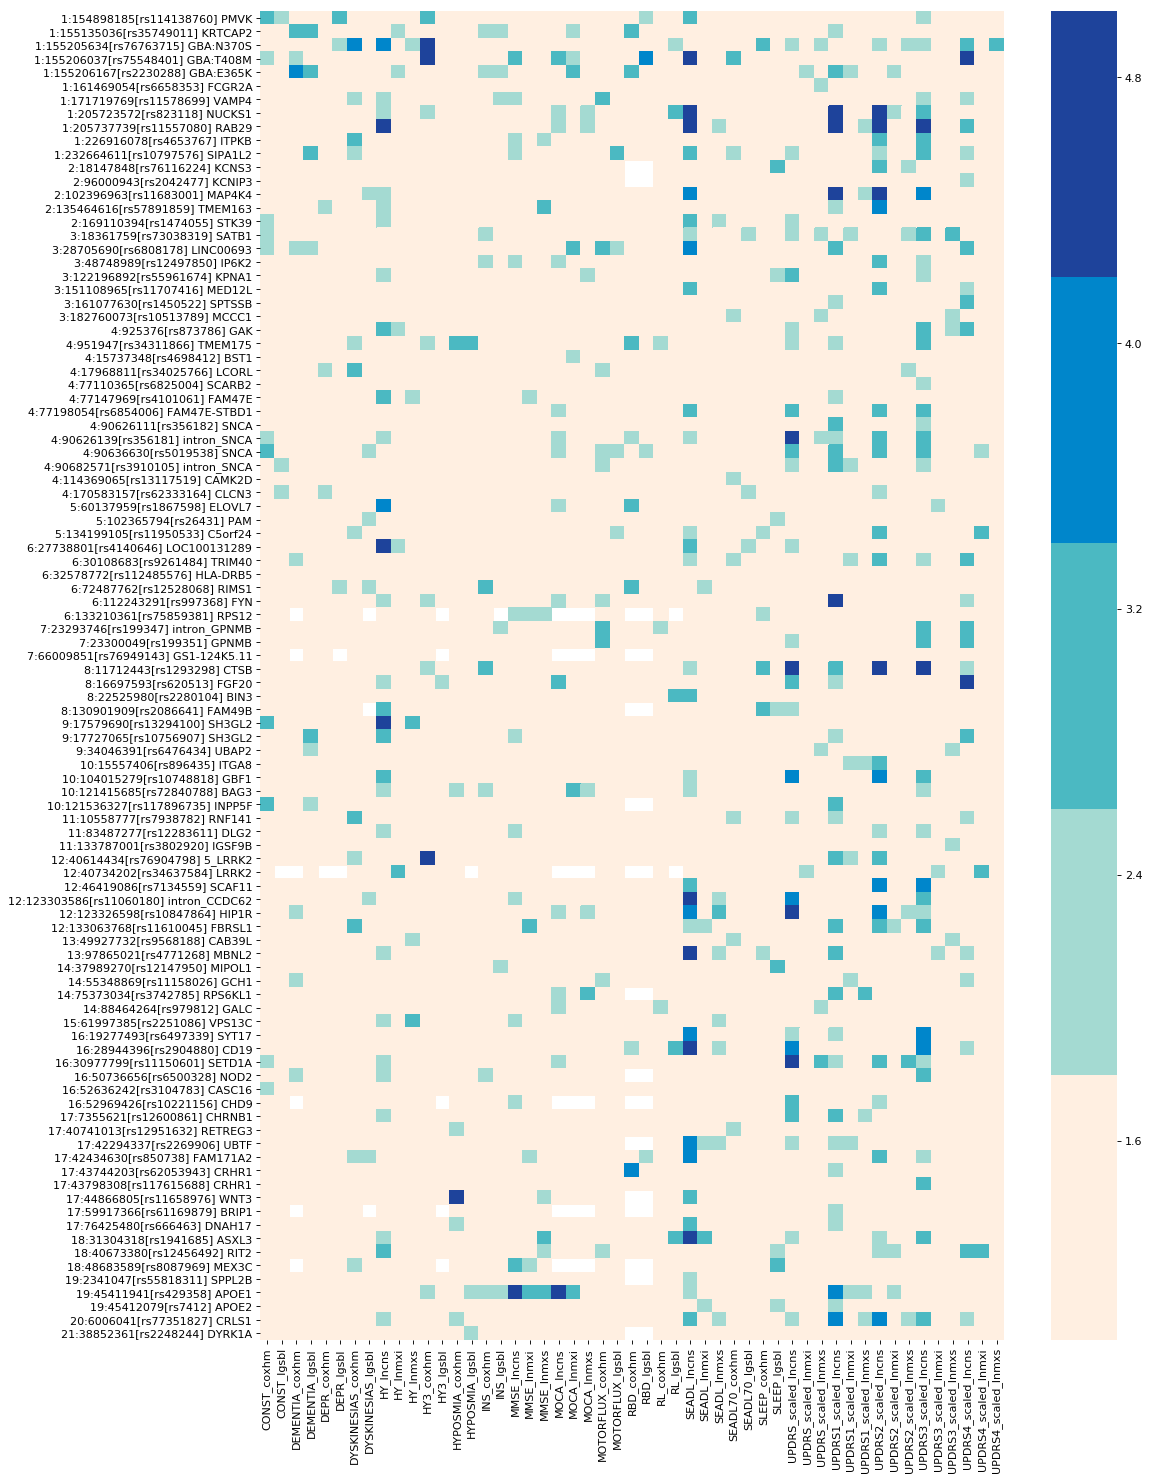

In [4]:
data  =  pd.read_table ("t/allV_snp.txt")
forIdx = data["POS"].str.split(":", expand=True).applymap(int).sort_values(by=[0, 1])
df = data.reindex(forIdx.index) # ordering by position
df_out = df.iloc [:, 3:]
df_out.index=df["POS"] + "[" + df['ID'] + "] " + df['NearGene']
n = 4
def cut_func(x):
    if x <= -np.log10(0.05):
        return 1
    elif x <= -np.log10(0.05/n):
        return 2
    elif x <= -np.log10(0.05/92):
        return 3
    elif x <= -np.log10(0.05/92/n):
        return 4
    elif x > -np.log10(0.05/92/n):
        return 5
    else:
        return np.nan
dft = df_out.iloc[:, :].applymap(cut_func) # apply significance category
_cmap = ["#ffefe1", "#a4dad2", "#4bb9c2", "#0086cb", "#1e439B"]
fig=plt.figure(figsize=(15, 22), dpi= 80, facecolor='w', edgecolor='k', )
sns.heatmap(dft, cmap=_cmap)
plt.savefig('fig/output.png', bbox_inches='tight', dpi=150)

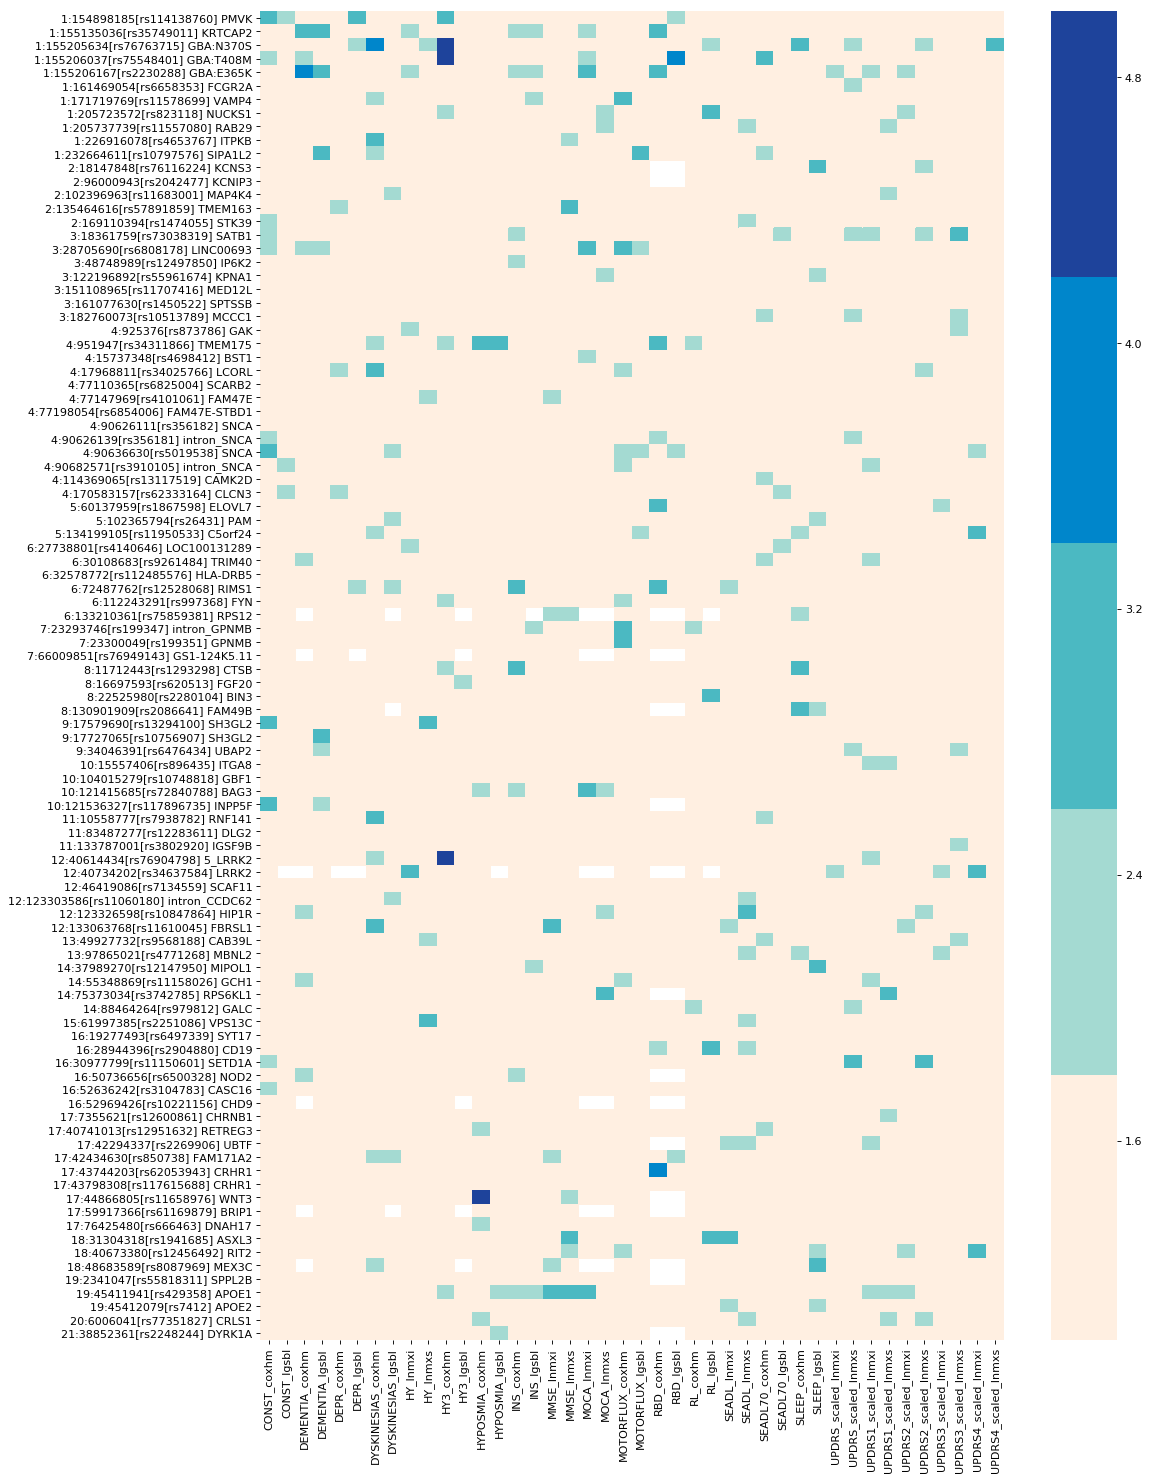

In [6]:
dft_select = dft.loc[:,[i for i in list(dft) if not "lncns" in i]]
_cmap = ["#ffefe1", "#a4dad2", "#4bb9c2", "#0086cb", "#1e439B"]
fig=plt.figure(figsize=(15, 22), dpi= 80, facecolor='w', edgecolor='k', )
sns.heatmap(dft_select, cmap=_cmap)

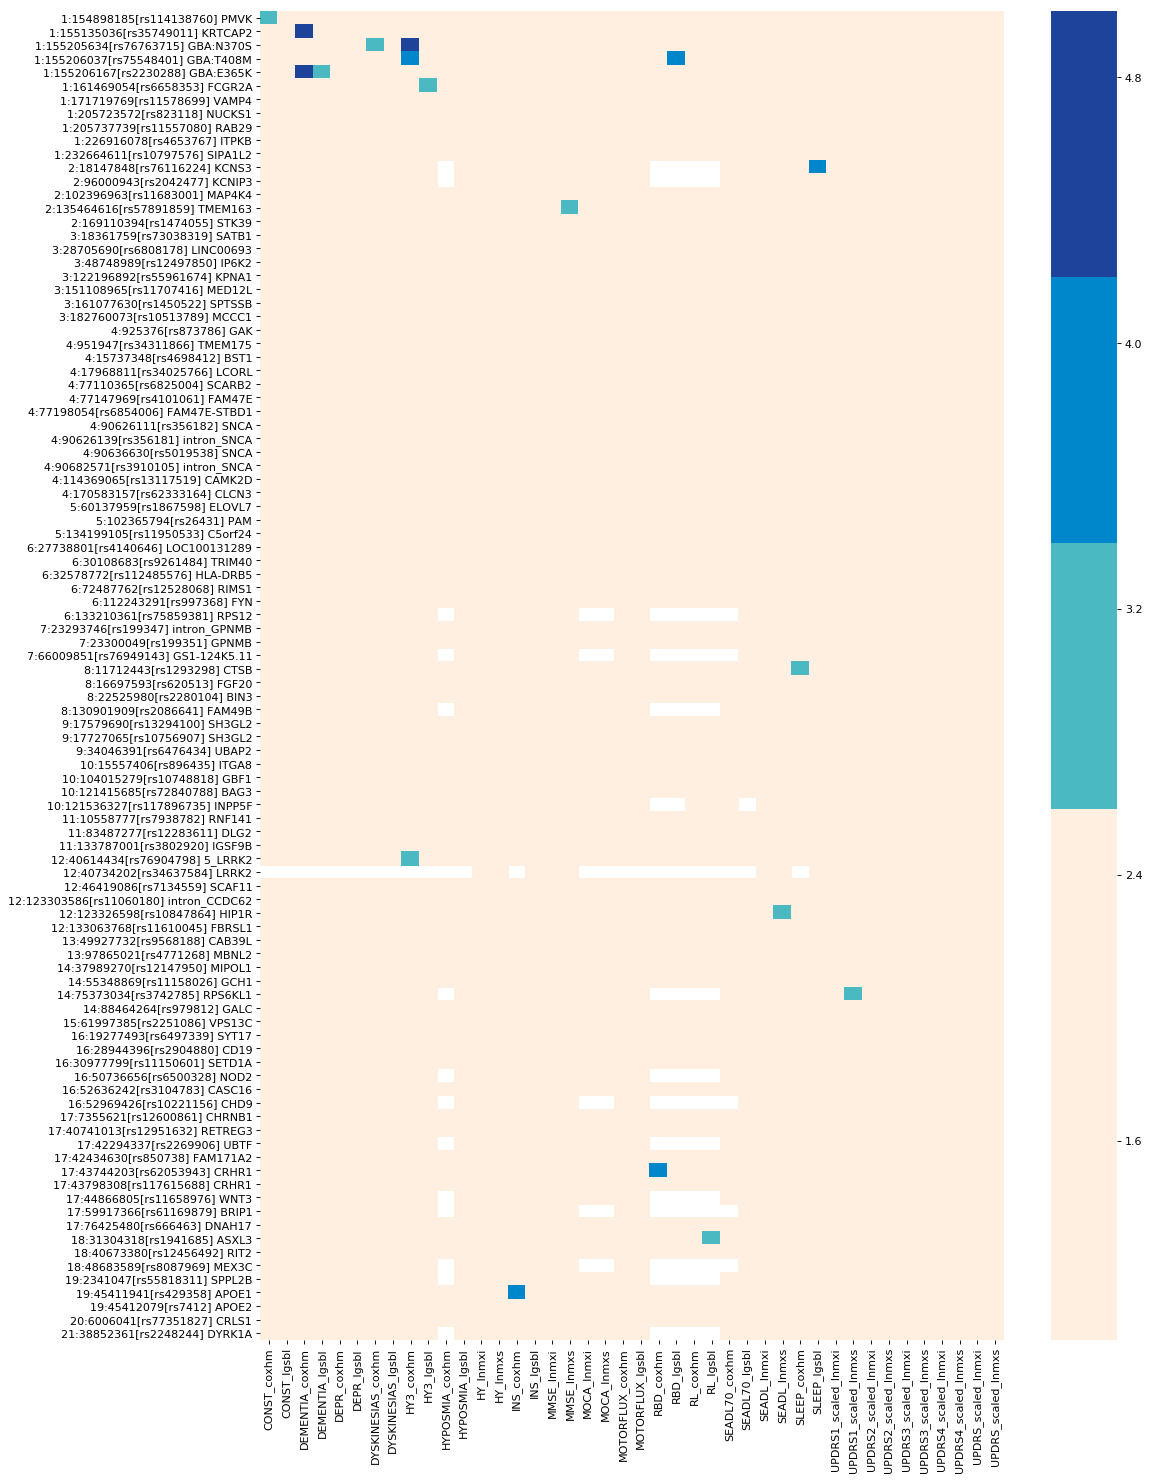

In [79]:
data  =  pd.read_table ("t/allV_snp.txt")
forIdx = data["POS"].str.split(":", expand=True).applymap(int).sort_values(by=[0, 1])
df = data.reindex(forIdx.index) # ordering by position
df_out = df.iloc [:, 3:]
df_out.index=df["POS"] + "[" + df['ID'] + "] " + df['NearGene']
n = 42
def cut_func(x):
    if x <= -np.log10(0.05):
        return 1
    elif x <= -np.log10(0.05/n):
        return 2
    elif x <= -np.log10(0.05/92):
        return 3
    elif x <= -np.log10(0.05/92/n):
        return 4
    elif x > -np.log10(0.05/92/n):
        return 5
    else:
        return np.nan
dft = df_out.iloc[:, :].applymap(cut_func) # apply significance category
dft_select = dft.loc[:,[i for i in list(dft) if not "lncns" in i]]
_cmap = ["#ffefe1", "#ffefe1", "#4bb9c2", "#0086cb", "#1e439B"]
fig=plt.figure(figsize=(15, 22), dpi= 80, facecolor='w', edgecolor='k', )
sns.heatmap(dft_select, cmap=_cmap)

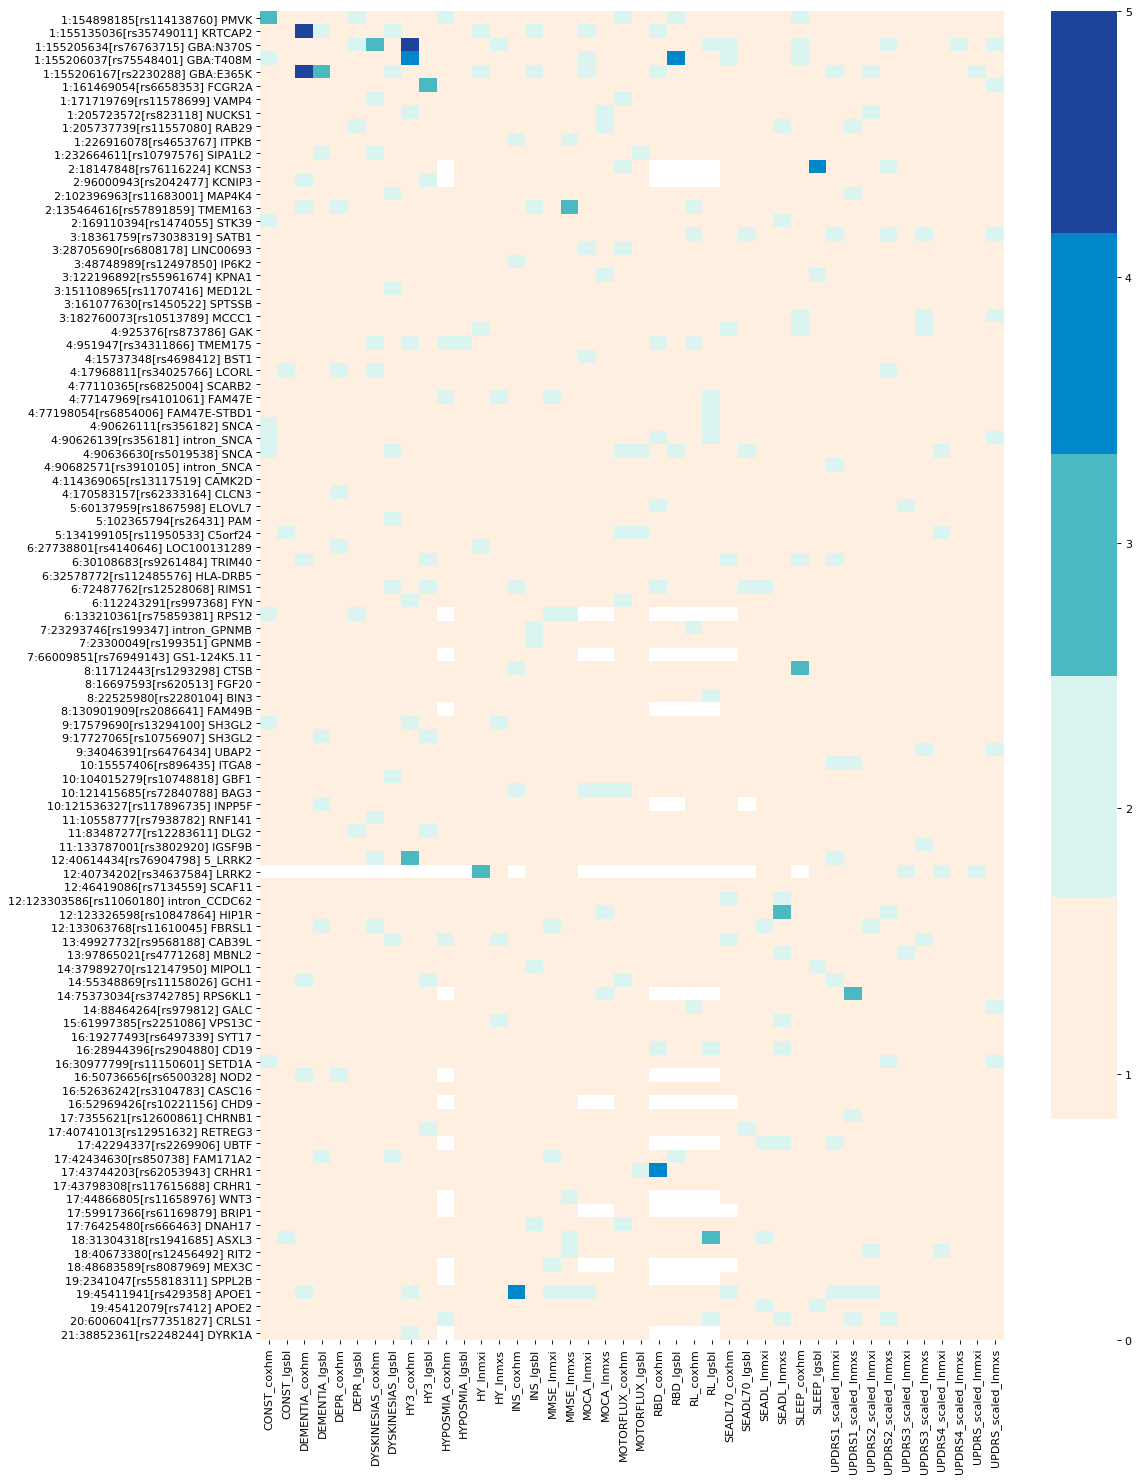

In [84]:
N_Variants=92 - df_out.isnull().sum(axis=0)
N_tests=42 - df_out.isnull().sum(axis=1)
t1=df_out.isnull() == False
t2=df_out > -np.log10(0.05)
t3=df_out.add(-np.log10(N_tests),axis=0) > -np.log10(0.05) 
t4=df_out.add(-np.log10(N_Variants),axis=1) > -np.log10(0.05) 
t5=df_out.add(-np.log10(N_tests),axis=0).add(-np.log10(N_Variants),axis=1) > -np.log10(0.05) 
dft=(t1*1).add(t2*1).add(t3*1).add(t4*1).add(t5*1)
dft_select = dft.loc[:,[i for i in list(dft) if not "lncns" in i]].astype('int')
_cmap = ["#FFFFFF", "#ffefe1", "#daf4f0", "#4bb9c2", "#0086cb", "#1e439B"]
fig=plt.figure(figsize=(15, 22), dpi= 80, facecolor='w', edgecolor='k', )
sns.heatmap(dft_select, cmap=_cmap)

In [75]:
t1

,CONST_coxhm,CONST_lgsbl,DEMENTIA_coxhm,DEMENTIA_lgsbl,DEPR_coxhm,DEPR_lgsbl,DYSKINESIAS_coxhm,DYSKINESIAS_lgsbl,HY3_coxhm,HY3_lgsbl,...,UPDRS2_scaled_lnmxs,UPDRS3_scaled_lncns,UPDRS3_scaled_lnmxi,UPDRS3_scaled_lnmxs,UPDRS4_scaled_lncns,UPDRS4_scaled_lnmxi,UPDRS4_scaled_lnmxs,UPDRS_scaled_lncns,UPDRS_scaled_lnmxi,UPDRS_scaled_lnmxs
1:154898185[rs114138760] PMVK,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:155135036[rs35749011] KRTCAP2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:155205634[rs76763715] GBA:N370S,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:155206037[rs75548401] GBA:T408M,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:155206167[rs2230288] GBA:E365K,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:161469054[rs6658353] FCGR2A,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:171719769[rs11578699] VAMP4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:205723572[rs823118] NUCKS1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:205737739[rs11557080] RAB29,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1:226916078[rs4653767] ITPKB,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
%%bash
# filtering meta-analysis results
## count the number of datasets in the meta-analysis
cut -d";" -f 1,3 models.txt | sort | uniq -c |sed 's/;/ /g'| awk 'BEGIN{OFS=","}{print $2,$3,$1}' | head # > t/NinMeta.csv
# RESULT=outGWAS
# for MODEL in coxhm lgsbl lncns lnmxi lnmxs;do
#     for i in $(grep ^"$MODEL" t/NinMeta.csv);do
#         OUTCOME=$(echo $i | cut -d, -f2)
#         N_COHORTs=$(echo $i | cut -d, -f3)
#         THRES=$(echo $[(N_COHORTs) / 2 ])
#         if [ $MODEL != lncns ];then
#             awk '$14>'$THRES' && $12<80 && $10+0 < 5e-7 {print $0}' meta/$RESULT/$MODEL/"$OUTCOME"1.tbl |
#                 > meta/$RESULT/$MODEL/"$OUTCOME"sig.txt
#         else
#             awk '$14>'$THRES' && $12<80 && $10+0 < 5e-9 {print $0}' meta/$RESULT/$MODEL/"$OUTCOME"1.tbl |
#                 > meta/$RESULT/$MODEL/"$OUTCOME"sig.txt
#         fi
#     done
# done

TYPE,OUTCOME,1
coxhm,,2
coxhm,CONST,6
coxhm,DEMENTIA,9
coxhm,DEPR,8
coxhm,DYSKINESIAS,7
coxhm,HY3,9
coxhm,HYPOSMIA,3
coxhm,INS,7
coxhm,MOTORFLUX,8


In [57]:
%%bash
for MODEL in lncns;do
    cat meta/outGWAS/$MODEL/*sig.txt > meta/outGWAS/"$MODEL"sig.txt
done

In [61]:
%%bash
cat meta/outGWAS/lncnssig.txt | sort | uniq -c | wc -l

9105


In [11]:
%%bash 
rm -f t/metathres.txt
for i in $(cat _meta_done.txt);do
  N_COHORTs=$(echo $i | sed 's/___/:/g' | cut -d ":" -f 3 | sed 's/,/\n/g' | wc -l)
  echo $[(N_COHORTs) / 2 ]  >> t/metathres.txt
done
paste -d '-' _meta_done.txt _metathres.txt > _meta_done_thres.txt
## Filtering HetIsq <80 HetDf > half of the number of the available cohorts.
ANALYSIS=surv
for i in $(grep ^"$ANALYSIS" _meta_done_thres.txt);do
  OUTCOME=$(echo $i | sed 's/___/:/g' | cut -d ":" -f 2)
  THRES=$(echo $i | cut -d "-" -f 2)
  awk '$14>'$THRES' {print $0}' $GNTYP_OUT/meta/$ANALYSIS/$OUTCOME/meta1.tbl | awk '$12<80' | sort -gk 10 > $GNTYP_OUT/meta/$ANALYSIS/$OUTCOME/meta2.tbl
done


ANALYSIS=rvtest
for i in $(grep ^"$ANALYSIS" _meta_done_thres.txt);do
  OUTCOME=$(echo $i | sed 's/___/:/g' | cut -d ":" -f 2)
  THRES=$(echo $i | cut -d "-" -f 2)
  awk '$14>'$THRES' {print $0}' $GNTYP_OUT/meta/$ANALYSIS/$OUTCOME/meta1.tbl | awk '$12<80' | sort -gk 10 > $GNTYP_OUT/meta/$ANALYSIS/$OUTCOME/meta2.tbl
done





RESULT=output
for MDOEL in "coxhm" "lgsbl" "lncns";do
    mkdir post/$RESULT/$MODEL
    RES_FOLDER="meta/$RESULT/$ANALYSIS"
    for OUTCOME in $(ls $RES_FOLDER);do
        awk '$10 < 5e-8 {print $1}' $RES_FOLDER/$OUTCOME/meta2.tbl > post/$ANALYSIS/sigV_"$OUTCOME".list
    done
done

1:161289441	t	c	0.1314	0.0026	0.1302	0.1646	1.6455	0.1971	7.038e-17	-+?-?-??-	100.0	14452.324	4	0


In [9]:
%%bash
mkdir -p t
module load plink
DATASET=PPMI

[+] Loading plink  1.9.0-beta4.4  on cn3301 


PPMI N_COL_638345 N_SNP_638339 N_ITER_31


In [48]:
%%bash 
awk '$35 > 0.05{print $0}' t/allV_info.csv | cut -f2- > t/allV_info2.csv

In [49]:
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
df=pd.read_csv("t/allV_info2.csv", sep='\t', keep_default_na=False, na_values="")
df.shape

(108, 38)

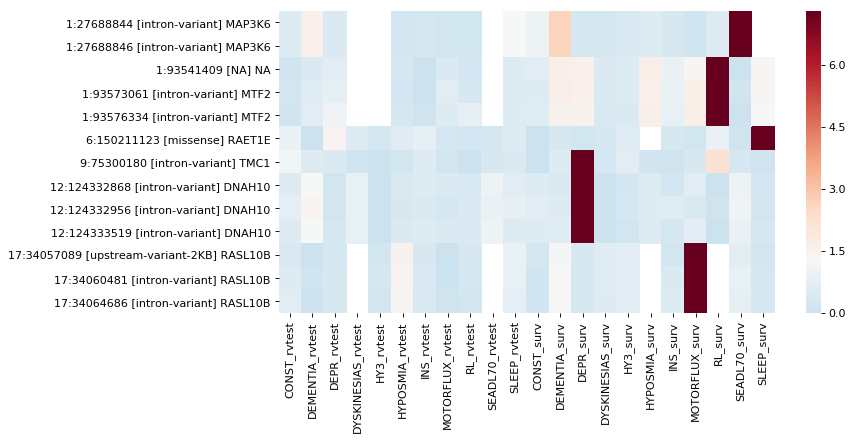

In [57]:
df_wo_slope = df.loc[:,[i for i in list(df) if not "slope" in i]]
df_wo_slope_sig = (df_wo_slope.iloc[:, 1:(df_wo_slope.shape[1]-6)] > 7.301).sum(axis=1)
df_wo_slop_less = df_wo_slope.loc[df_wo_slope_sig>0]
dft = df_wo_slop_less
dft_out = dft.iloc[:, 1:(dft.shape[1]-6)]
dft_out.index = dft['V1'] + " [" + dft['FXNCLASS'] + "] " + dft['SYMBOL']
dft_out.head()
fig=plt.figure(figsize=(10,5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(dft_out,cmap='RdBu_r', vmin=0, center=1.301, vmax=7.301)